# Решение домашнего задания #5

Для решения будем использовать Mamba модель из простой имплементации на торче (https://github.com/myscience/mamba), однако немного упрощена для большей компактности.

### Базовая настройка

In [61]:
from mamba import LLMMamba, MambaConfig

import torch
from torch.utils.data import DataLoader

from lightning.pytorch import Trainer, LightningModule

from transformers import GPT2Tokenizer

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [62]:
torch.set_float32_matmul_precision('medium')

In [63]:
TARGET_ROW = "To prove that"

In [64]:
config = MambaConfig(
    vocab_size=50304,
    num_layers=12,
    d_input=64,
    d_model=128,
    d_state=64,
    ker_size=12,
    parallel=True
)

### Загрузка датасета (датасет латеховских статей) и токенайзера (токенайзер GPT-2)

In [65]:
train_ds = pd.concat([pd.read_parquet(f'../../data/proof-pile/000{i}.parquet') for i in range(3)], ignore_index=True)
text_data = train_ds['text'].tolist()

In [66]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

1

### Теперь нам нужен кастомный лоадер для тренировки

In [67]:
class CustomLoader(DataLoader):
    def __init__(self, texts, tokenizer, loader_size=16, batch_size=16, block_size=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.block_size = block_size
        self.loader_size = loader_size

        self.text_id = -self.loader_size
        self.page_tokens = None
        self.page_training_pairs = None

        self.next_page()

        super().__init__(self, batch_size=batch_size)

    def next_page(self):
        self.text_id += self.loader_size
        if self.text_id + self.loader_size > len(self.texts):
            self.text_id = 0
        self.page_tokens = [
            self.tokenizer.encode(self.texts[self.text_id + i])
            for i in range(self.loader_size)
        ]
        self.page_training_pairs = torch.tensor([
            [
                tokens[i:i + self.block_size],
                tokens[i + 1:i + self.block_size + 1]
            ]
            for tokens in self.page_tokens
            for i in range(0, len(tokens) - self.block_size)
        ])
        self.page_training_pairs = self.page_training_pairs[torch.randperm(len(self.page_training_pairs))]

    def __iter__(self):
        for i in range(0, len(self.page_training_pairs), self.batch_size * 30):
            yield self.page_training_pairs[i:i + self.batch_size, 0, :], self.page_training_pairs[i:i + self.batch_size, 1, :]

    def __len__(self):
        return len(self.page_training_pairs) // self.batch_size // 30

### Теперь мы готовы к обучению

In [68]:
dl = CustomLoader(text_data, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (7399 > 1024). Running this sequence through the model will result in indexing errors


In [69]:
class LightningMamba(LightningModule):
    def __init__(self, config, tokenizer):
        super().__init__()
        self.model = LLMMamba(config)
        self.tokenizer = tokenizer

        self.loss_history = []

    def forward(self, idx):
        return self.model(idx)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95), fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }
    
    def training_step(self, batch, batch_idx):
        idx, targets = batch
        loss = self.model.compute_loss(idx, targets)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        self.loss_history.append(loss.item())
        return loss
    
    def on_train_epoch_start(self):
        seg_generator = self.model.generate(
            prompt=TARGET_ROW,
            tokenizer=self.tokenizer,
            token_lim=10,
            use_top_k=10
        )
        generated_text = "".join([seg[0] for seg in seg_generator])
        print('test/generated_text', generated_text)
        
        return super().on_train_epoch_start()
    
    def on_train_epoch_end(self):
        dl.next_page()

        return super().on_train_epoch_end()

In [70]:
model = LightningMamba(config, tokenizer)

In [74]:
trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False,
)
trainer.fit(model, train_dataloaders=dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | LLMMamba | 7.1 M  | train
-------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.303    Total estimated model params size (MB)
137       Modules in train mode
0         Modules in eval mode
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

test/generated_text To prove thatumsheard 107stableCPU underest professorsossibleRAM Historically
test/generated_text To prove thatx\isc be$.tX:.

test/generated_text To prove that
H_{\,\mathp\_
test/generated_text To prove that
\inpright|)\}{{D
test/generated_text To prove that
\labelma(\i\le
\
test/generated_text To prove that}$, $\sum x,T of $
test/generated_text To prove that \eqref}$ is \sub have:
test/generated_text To prove that the}$.}
\times,-1
test/generated_text To prove that
\text $\math{\t,\in
test/generated_text To prove that $^
(H~ a ( ({


`Trainer.fit` stopped: `max_epochs=10` reached.


<Axes: >

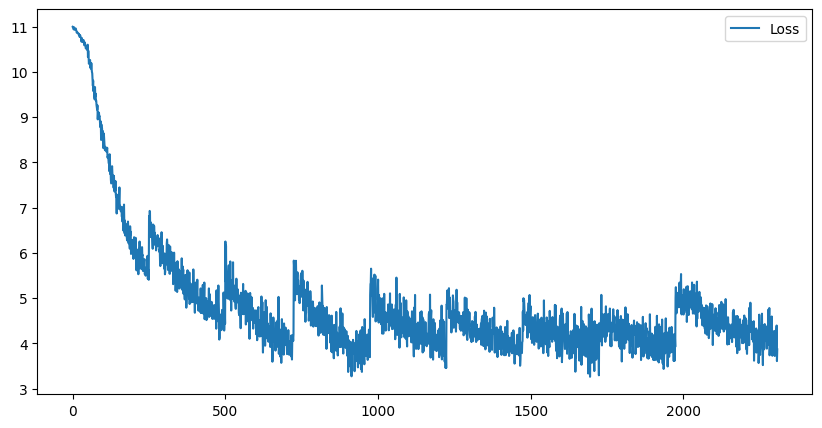

In [75]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history, label='Loss')

### Смотрим, что же получилось

_предварительно откатываем модель до 3-ей эпохи_

In [76]:
generated_text = "".join([tok[0] for tok in model.model.generate(
    TARGET_ROW,
    tokenizer=tokenizer,
    token_lim=300,
    use_top_k=10
)])
print('test/generated_text', generated_text)

test/generated_text To prove that$ is.., $-set the same $x/$ or the the the first,\]
\le
\label)\sub\_(cf,
:  alpha +t,$1}\\ $^_{\]
\left
\in{x|}
\in (\hat, we get(|,0,s, for the)a}{{Iau(x)\  the have ( aend^\in x-r $T]\{v \in+ \phi\ta 1}{[
\in^{n| \text{\_j}$u1} \begin}{0}(\mu_1,t, | \c^
\|_A_t)$ be by $\(s, we\times}
\label in that$ c-W\label{eqref2|}{{x^|n_M^{,t-S}.
\label{t, ( \eqref
\{align_{*,w ((\R_{j= \c-4^{\alpha^\d \math a The a:}{{$ with that the a)$\end.n \em suchmathcal{proofumber aite}  \frac|,\d   O,r*[0)\+\v}\}$ and     ref(sin\


In [77]:
def plot_weights(mamba_block, title='Attention Weights'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    matrixes = [mamba_block.in_proj.weight, mamba_block.out_proj.weight, mamba_block.s_B.weight, mamba_block.s_C.weight, mamba_block.s_D[0].weight, mamba_block.s_D[1].weight, mamba_block.A, mamba_block.conv.weight.squeeze()]
    names = ["Input Projection", "Output Projection", "state B", "state C", "state D In", "state D Out", "A Weights", "Conv Weights"]

    for i, (matrix, name) in enumerate(zip(matrixes, names)):
        sns.heatmap(matrix.detach().cpu().numpy(), ax=ax[i // 3][i % 3])
        ax[i // 3][i % 3].set_title(name)
        ax[i // 3][i % 3].axis('off')

    ax[2][2].axis('off')  # Hide the last subplot if not used

    plt.tight_layout()
    plt.show()

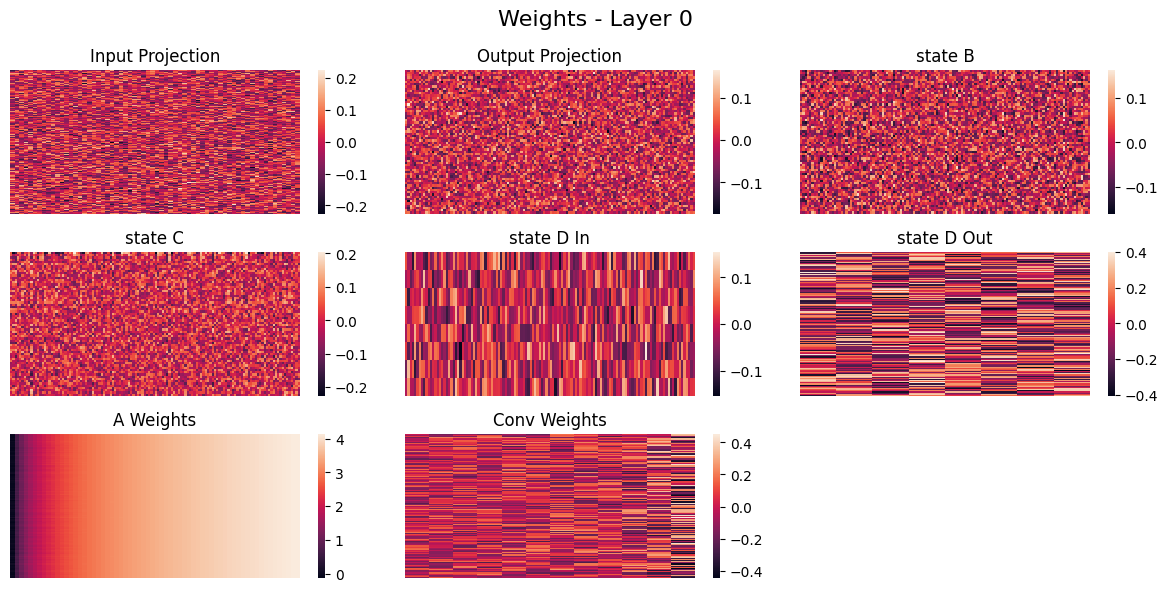

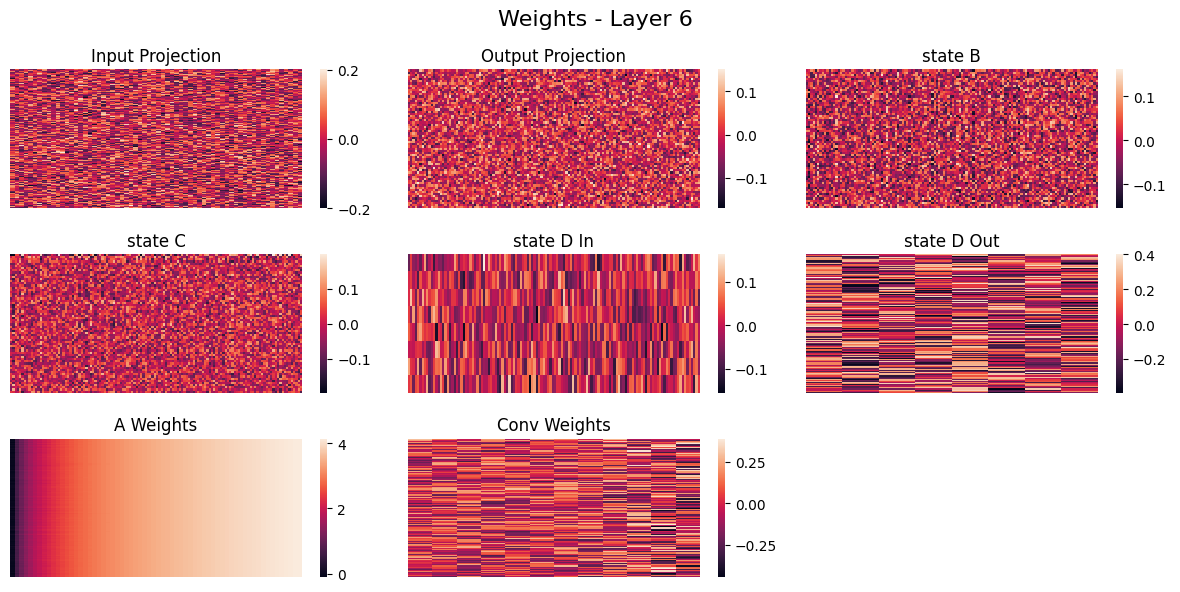

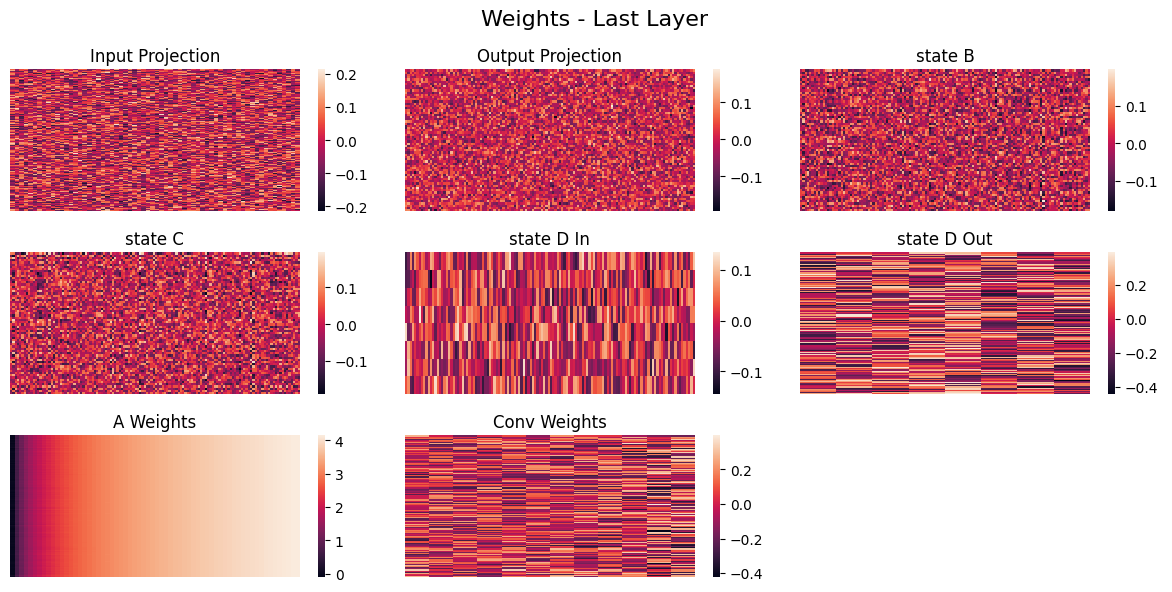

In [78]:
plot_weights(model.model.layers[0][0], title='Weights - Layer 0')
plot_weights(model.model.layers[6][0], title='Weights - Layer 6')
plot_weights(model.model.layers[-1][0], title='Weights - Last Layer')

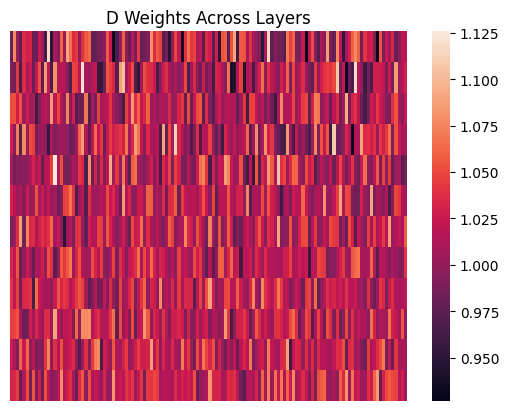

In [79]:
sns.heatmap([model.model.layers[i][0].D.data for i in range(len(model.model.layers))])
plt.title('D Weights Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('D Weights')
plt.axis('off')
plt.show()

# Итоги

|                           | Mamba     | GPT         | MambaPy                | 
|---------------------------|-----------|-------------|------------------------|
| Training time             | 10m 8.0s  | **3m 4.2s** | 10m 23.0s  (slow mode) |
| 300 token generation time | 5.8s      | 9.5s        | **5.3s** (slow mode)   |
| Size                      | **7.1 M** | 15.0 M      | **7.1 M**              |
| Quality                   | 1/5       | 4/5         | 4/5                    |

_Стоит отметить, что несмотря на невероятно плохие результаты, проблема скорее всего в имплементации (и вероятнее всего в генераторе, судя по наличию прогресса нисходящего тренда лосса), т.к. я дополнительно запустил код на библиотечной имплементации mambapy ([./mambapy_test.ipynb](mambapy_test.ipynb)) и результаты там были сильно лучше, поэтому выводы будут сделаны именно по ней_

1. Качество `Mamba` оказалось на ровне с GPT, однако существенного прироста в скорости не было (даже на генерации 1000 токенов). По большей степени снижение скорости обусловлено малым числом параметров (что однако слабо повлияло на качество).
2. Стоит отметить, что архитектура `Mamba` также показала довольно сильную способность к обучению уже с первых итераций.
3. Также стоит отметить, что в отличие от `GPT` интерпретировать веса `Mamba` практически невозможно. А сами они выглядят как случайный шум.